In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Introduction

need to do

# Data

The dataset I chose to explore is the famous Titanic dataset.  The dataset can be found here, https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html



In [2]:
df = pd.read_csv('titanic.csv')

In [3]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'Siblings/Spouses Aboard',
       'Parents/Children Aboard', 'Fare'],
      dtype='object')

In [4]:
df.drop('Name', axis=1, inplace=True)

In [5]:
df.head()

,Survived,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


In [6]:
df.isnull().sum()

Survived                   0
Pclass                     0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

In [7]:
df = pd.get_dummies(df) # maybe instead of get dummies replace with 1 male -1 female

In [8]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [9]:
df.head()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male
0,0,3,22.0,1,0,7.2500,0,1
1,1,1,38.0,1,0,71.2833,1,0
2,1,3,26.0,0,0,7.9250,1,0
3,1,1,35.0,1,0,53.1000,1,0
4,0,3,35.0,0,0,8.0500,0,1


# Initial 2D view of the dataset using UMAP

I chose to use UMAP instead of PCA and tSNE because it preverse more local clustering than PCA and is faster than tSNE
I'm setting n-companents equal to 2 and leaving the rest of the parameters as their defaults

In [91]:
#X_initial = StandardScaler().fit_transform(X)
X_inital = MinMaxScaler().fit_transform(X)

In [92]:
umap2 = UMAP(n_components=2)

In [93]:
X_initial_2d = umap2.fit_transform(X_initial)

<AxesSubplot:>

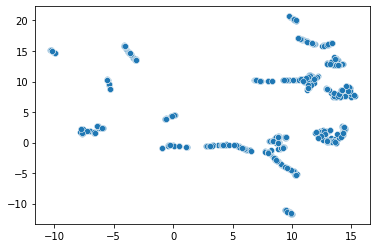

In [94]:
sns.scatterplot(x=X_initial_2d[:,0],y=X_initial_2d[:,1])

Although nothing can be inferred, there appear to be ten or more clusters.

In [95]:
df['x'] = X_initial_2d[:,0]
df['y'] = X_initial_2d[:,1]

# Clustering all data using KMeans

* use inertia to find the best k or k values
* Check consistency (will do this eventually when I pick the clustering method)
* Look at silhouette score

In [96]:
inertia_values = []
for n in range(2,21):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_initial)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))


<AxesSubplot:>

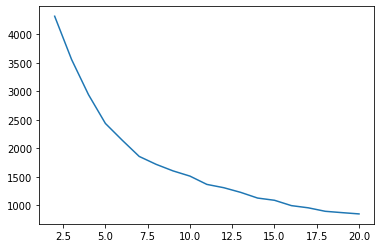

In [97]:
sns.lineplot(x=results[0],y=results[1])

It is hard to see an elbow.  I would say 6 or 11.

Checking for a more pronounced elbow by adjusting other parameters of the k means algorithm

<AxesSubplot:>

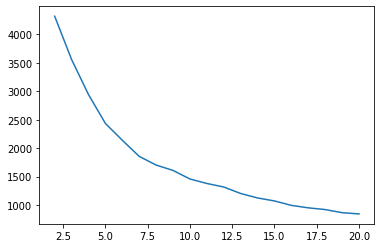

In [98]:
inertia_values = []
for n in range(2,21):
    kmeans = KMeans(n_clusters=n, algorithm='full')
    kmeans.fit(X_initial)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
sns.lineplot(x=results[0],y=results[1])

<AxesSubplot:>

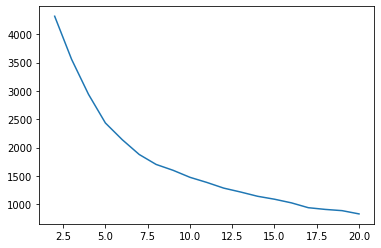

In [18]:
inertia_values = []
for n in range(2,21):
    kmeans = KMeans(n_clusters=n, algorithm='elkan')
    kmeans.fit(X_initial)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))
sns.lineplot(x=results[0],y=results[1])

The three graphs look similar.  I will choose 6 for kmeans

In [99]:
kmeans = KMeans(n_clusters=6)
#labels = kmeans.fit_predict(X_initial)
df['kmeans_labels'] = kmeans.fit_predict(X_initial)

Visualizing the data

<AxesSubplot:xlabel='x', ylabel='y'>

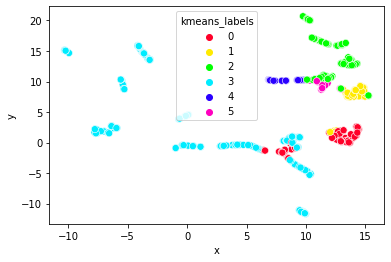

In [100]:
sns.scatterplot(x='x',y='y', hue='kmeans_labels', data=df, palette='gist_rainbow', s=50)
#sns.scatterplot(x=X_initial_2d[:,0],y=X_initial_2d[:,1], hue=labels, palette='gist_rainbow', s=50)

There does seem some mixing of clusters, going to get the silhouette score.

In [101]:
silhouette_score(X_initial, df['kmeans_labels'])

0.41224544461075413

# Hierarchal Clustering

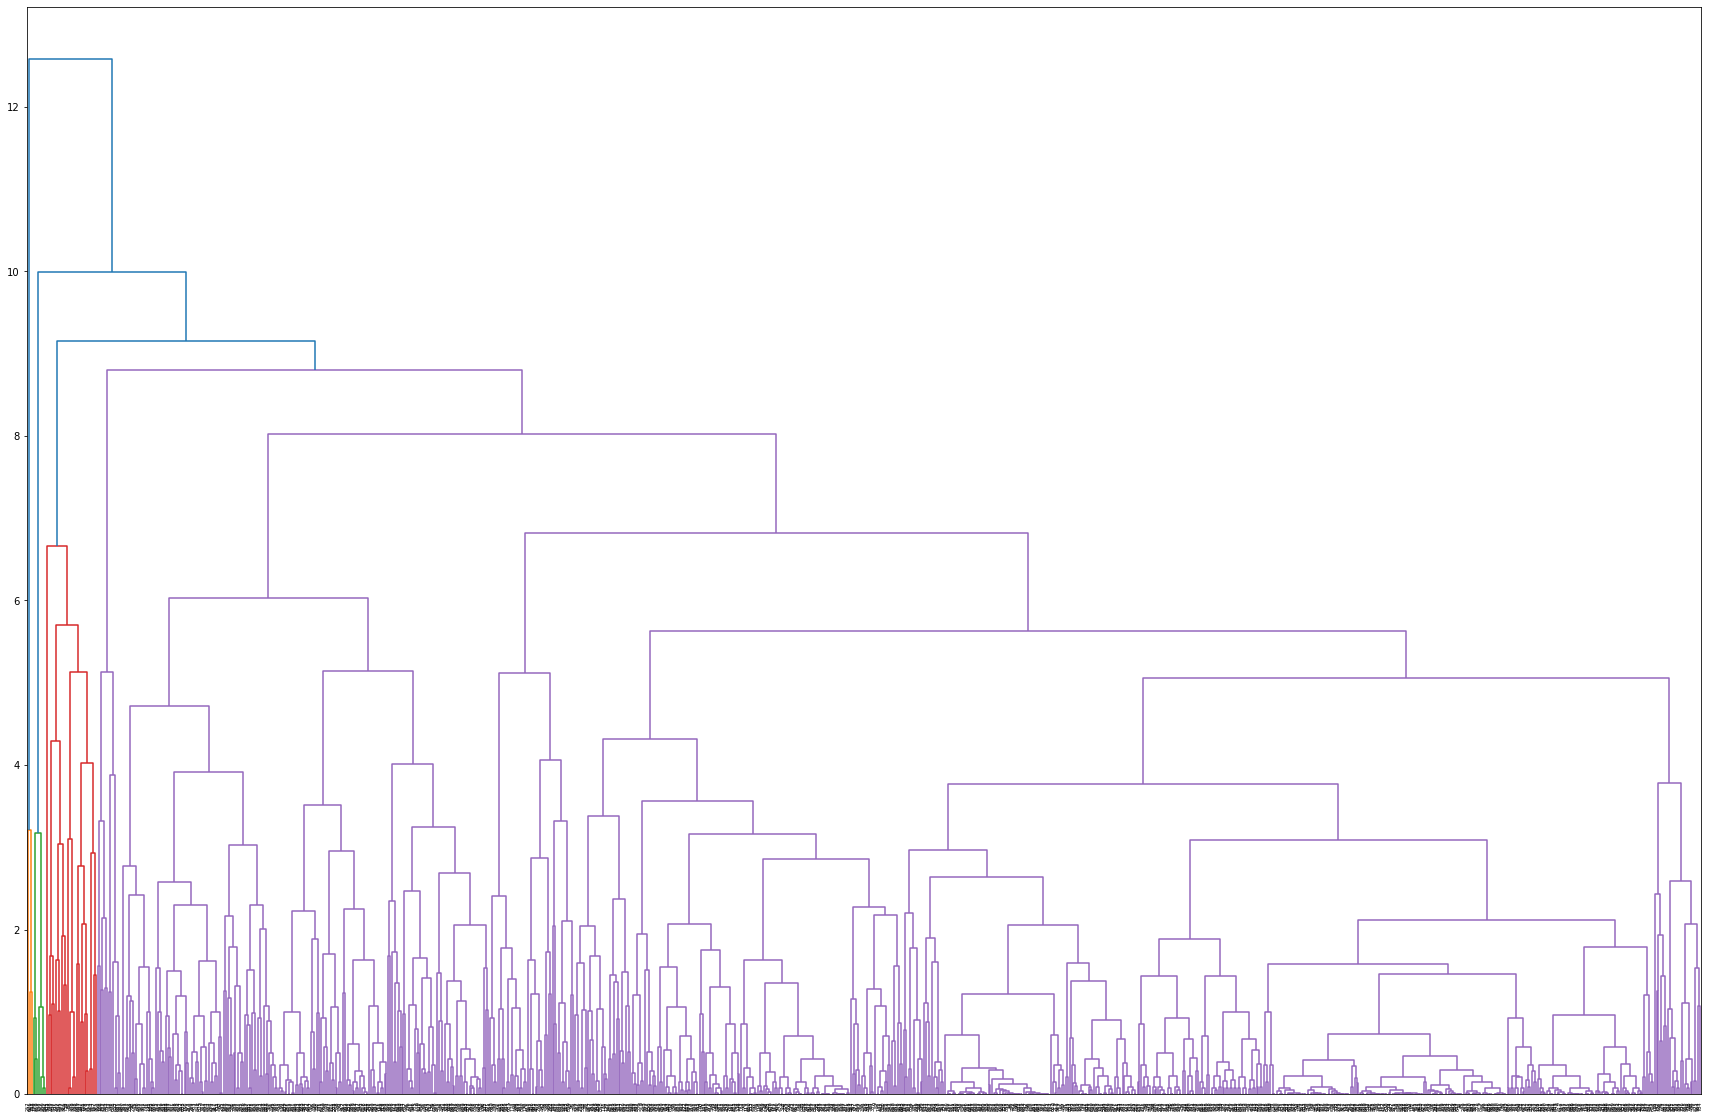

In [102]:
plt.figure(figsize=(30,20))
dendrogram(linkage(X_initial, method='complete'))
plt.show()

From the graph you see there are large groups that join early and small groups that do not get joined until later.

In [103]:
agg = AgglomerativeClustering(n_clusters=None, distance_threshold=10,compute_full_tree=True)

In [104]:
agg.fit(X_initial)

AgglomerativeClustering(compute_full_tree=True, distance_threshold=10,
                        n_clusters=None)

In [105]:
agg.n_clusters_

18

In [106]:
df['agg_labels'] = agg.fit_predict(X_initial)

In [107]:
silhouette_score(X_initial, df['agg_labels'])

0.37800739149484835

In [42]:
# need to probably research more about this to find out how to chose distance_threshold or n_clusters

# Clustering using DBSCAN

In [108]:
db = DBSCAN()

In [109]:
df['dbscan_labels']=db.fit_predict(X_initial)

In [110]:
# now get the silhouette score for those that are not outlers
silhouette_score(X_initial[df['dbscan_labels']!=-1],df[df['dbscan_labels']!=-1]['dbscan_labels'])

0.40378531606294216

In [111]:
df['dbscan_labels'].max()

20

# Comparing clusters

In [121]:
stats = {}
for n in range(6):
    stats['mean_cluster_{}'.format(n)] = df[df['kmeans_labels']==n].mean()
    stats['std_cluster_{}'.format(n)] = df[df['kmeans_labels']==n].std()
(pd.DataFrame(stats)).transpose()
    

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,x,y,kmeans_labels,agg_labels,dbscan_lables,dbscan_labels
mean_cluster_0,0.272152,1.329114,43.911392,0.291139,0.170886,39.965137,0.000000,1.000000,11.870335,0.405455,0.0,4.544304,4.132911,4.132911
std_cluster_0,0.446483,0.546477,13.408990,0.495891,0.467995,29.985558,0.000000,0.000000,2.491104,1.484023,0.0,1.721335,3.827664,3.827664
mean_cluster_1,0.908163,1.000000,35.723673,0.591837,0.510204,127.046174,0.897959,0.102041,14.265434,7.691769,1.0,5.704082,3.806122,3.806122
std_cluster_1,0.290280,0.000000,13.720751,0.701056,0.815379,95.489800,0.304258,0.304258,0.783267,1.733812,0.0,5.960712,7.674645,7.674645
mean_cluster_2,0.713450,2.596491,25.584795,0.426901,0.228070,14.834919,1.000000,0.000000,12.049735,14.594955,2.0,12.070175,4.678363,4.678363
std_cluster_2,0.453477,0.526687,11.772449,0.631694,0.420820,7.695433,0.000000,0.000000,1.407858,3.315948,0.0,6.253074,5.547289,5.547289
mean_cluster_3,0.161376,2.820106,26.191138,0.214286,0.121693,12.096669,0.000000,1.000000,1.428645,2.321076,3.0,4.912698,3.701058,3.701058
std_cluster_3,0.368365,0.384608,9.664250,0.482156,0.386792,10.673404,0.000000,0.000000,6.799948,7.488747,0.0,1.582496,3.560474,3.560474
mean_cluster_4,0.073171,3.000000,8.463415,4.536585,1.609756,38.327849,0.414634,0.585366,8.076830,10.204188,4.0,11.804878,3.585366,3.585366
std_cluster_4,0.263652,0.000000,5.652865,1.704370,0.493865,16.466870,0.498779,0.498779,1.122283,0.056283,0.0,1.364176,6.395215,6.395215


In [122]:
stats2 = {}
for n in range(21):
    stats2['mean_cluster_{}'.format(n)] = df[df['dbscan_labels']==n].mean()
    stats2['std_cluster_{}'.format(n)] = df[df['dbscan_labels']==n].std()
(pd.DataFrame(stats2)).transpose()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,x,y,kmeans_labels,agg_labels,dbscan_lables,dbscan_labels
mean_cluster_0,0.125000,3.0,25.125000,1.0,0.0,1.314619e+01,0.0,1.0,9.683719,-11.370476,3.000000,4.000000,0.0,0.0
std_cluster_0,0.337832,0.0,5.818356,0.0,0.0,5.090010e+00,0.0,0.0,0.209160,0.237991,0.000000,0.000000,0.0,0.0
mean_cluster_1,1.000000,1.0,36.916667,1.0,0.0,7.125833e+01,1.0,0.0,14.802672,8.458772,1.000000,2.000000,1.0,1.0
std_cluster_1,0.000000,0.0,4.621262,0.0,0.0,2.121088e+01,0.0,0.0,0.078836,0.212631,0.000000,0.000000,0.0,0.0
mean_cluster_2,0.625000,3.0,23.008929,0.0,0.0,8.146805e+00,1.0,0.0,10.670053,18.190702,2.000000,15.000000,2.0,2.0
std_cluster_2,0.488504,0.0,5.558361,0.0,0.0,1.243701e+00,0.0,0.0,0.651510,1.815759,0.000000,0.000000,0.0,0.0
mean_cluster_3,0.106719,3.0,28.808300,0.0,0.0,8.203751e+00,0.0,1.0,-2.144070,5.546092,2.928854,4.533597,3.0,3.0
std_cluster_3,0.309368,0.0,10.840740,0.0,0.0,2.576443e+00,0.0,0.0,4.858902,6.403794,0.457388,1.149473,0.0,0.0
mean_cluster_4,0.333333,1.0,44.007576,0.0,0.0,2.917796e+01,0.0,1.0,13.859307,1.105586,0.000000,3.818182,4.0,4.0
std_cluster_4,0.475017,0.0,11.612491,0.0,0.0,1.148739e+01,0.0,0.0,0.507162,0.900986,0.000000,1.346324,0.0,0.0


In [120]:
df[df['dbscan_labels']==0].Pclass.unique()

array([3], dtype=int64)

# Looking at what DBSCAN calls outliers

In [112]:
df[df['dbscan_labels']==-1]

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female,Sex_male,x,y,kmeans_labels,agg_labels,dbscan_lables,dbscan_labels
7,0,3,2.0,3,1,21.0750,0,1,6.840234,10.315262,4,13,-1,-1
8,1,3,27.0,0,2,11.1333,1,0,11.434028,9.533051,5,0,-1,-1
9,1,2,14.0,1,0,30.0708,1,0,13.858843,13.514400,2,16,-1,-1
10,1,3,4.0,1,1,16.7000,1,0,10.727857,10.346480,2,0,-1,-1
11,1,1,58.0,0,0,26.5500,1,0,14.598742,9.323020,1,2,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,1,1,56.0,0,1,83.1583,1,0,14.184462,8.591401,1,2,-1,-1
876,1,2,25.0,0,1,26.0000,1,0,11.842891,10.410314,2,0,-1,-1
881,0,3,39.0,0,5,29.1250,1,0,11.365204,8.908839,5,8,-1,-1
883,1,1,19.0,0,0,30.0000,1,0,15.255247,7.720529,2,2,-1,-1
